In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def f(x):
  return 3*x**2 - 4*x + 5

In [11]:
f(3.0)

20.0

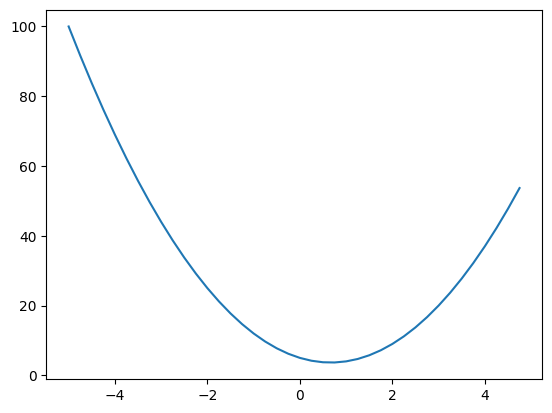

In [12]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)


In [13]:
h = 0.0002
x = 3.0
f(x)

20.0

In [14]:
h = 0.02
x = 3.0
f(x + h)

20.2812

In [15]:
h = 0.02
x = 3.0
f(x + h) - f(x)

0.28119999999999834

In [16]:
class Value:
  def __init__(self, data, _children = (), _op = '', label = ''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label= label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): #other * self
    return self * other

  def __truediv__(self, other):  #self / other
    return self * other**-1

  def __neg__(self): #-self
    return self * -1

  def __sub__(self, other): #self - other
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [17]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [18]:
from graphviz import Digraph

def trace(root):
  #builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    #for any value is a result of some operation, create an op node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      #if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      #and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


L = d * f

dl/dd = ? f

f(x + h) - f(x)/h

((d + h) * f - d * f)/h

(d*f + h*f - d*f) / h

(h*f)/h

f

dd/dc = 1.0

dd/de = 1.0

d = c + e

WANT:

dL/dc = (dl/ dd) * (dd/dc)

KNOW:

dl/dd

dd/dc

dl / de = -2

e = a * b

de / da = b

de / db = a

dl/da = (dl/de) * (de / da)



In [19]:
#inputs x1, x2

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias of the neuron
b = Value(6.8813735870195432, label = 'b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

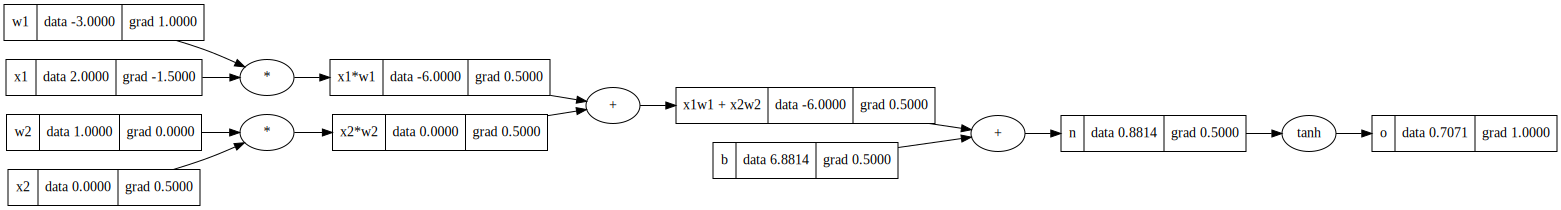

In [20]:
draw_dot(o)

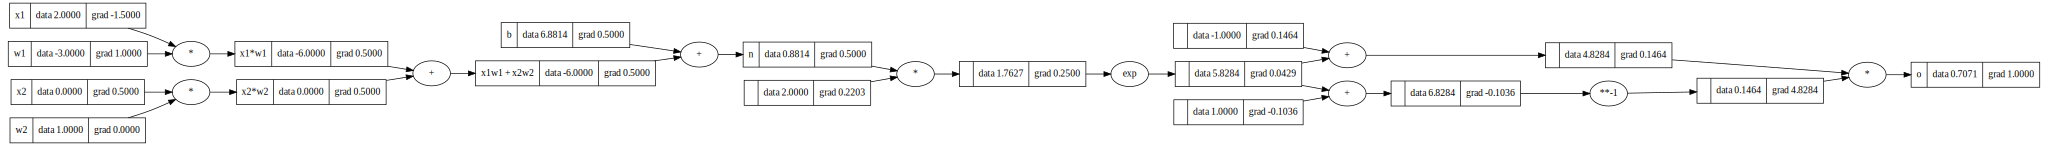

In [21]:
#inputs x1, x2

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias of the neuron
b = Value(6.8813735870195432, label = 'b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ---
o.label = 'o'
o.backward()
draw_dot(o)

In [22]:
import torch

In [23]:
x1 = torch.Tensor([2.0]).double()               ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ;b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [24]:
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    #w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [25]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9202605287471939)

In [30]:
n.parameters()

[Value(data=0.55798750926328),
 Value(data=-0.8653826358507022),
 Value(data=-0.12915036602182406),
 Value(data=-0.7239322290727859),
 Value(data=-0.9172237392952685),
 Value(data=-0.6190838147398199),
 Value(data=-0.4686589525828768),
 Value(data=0.2650608068837208),
 Value(data=0.047596773264946934),
 Value(data=-0.9482233090527112),
 Value(data=0.899859641655653),
 Value(data=0.47524415406193654),
 Value(data=-0.030410770204903903),
 Value(data=-0.3979805977940425),
 Value(data=-0.4645700663283123),
 Value(data=0.8191119774642766),
 Value(data=-0.05029969246822841),
 Value(data=-0.6242093752550864),
 Value(data=-0.3452837670219202),
 Value(data=0.3161003615613174),
 Value(data=0.5369797110286731),
 Value(data=0.5648173959103377),
 Value(data=0.5403727274125849),
 Value(data=0.6504229114319822),
 Value(data=-0.7810823913645297),
 Value(data=0.5831777446911386),
 Value(data=0.0010929618385679962),
 Value(data=0.004019816950358024),
 Value(data=-0.6599958129717556),
 Value(data=-0.4645

In [126]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] #desired output


In [132]:
for k in range(30):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k, loss.data)

0 0.0005254977167397832
1 0.0005243720172667439
2 0.0005232524958132768
3 0.0005221391009388735
4 0.0005210317817686926
5 0.000519930487985859
6 0.0005188351698238729
7 0.0005177457780591581
8 0.000516662264003695
9 0.0005155845794978286
10 0.0005145126769031339
11 0.0005134465090954241
12 0.000512386029457889
13 0.0005113311918742963
14 0.0005102819507223495
15 0.0005092382608671101
16 0.0005082000776545602
17 0.0005071673569052294
18 0.0005061400549079559
19 0.0005051181284137265
20 0.000504101534629636
21 0.0005030902312128763
22 0.0005020841762649244
23 0.0005010833283257159
24 0.0005000876463679796
25 0.0004990970897916442
26 0.0004981116184182776
27 0.0004971311924857224
28 0.0004961557726426814
29 0.0004951853199435142


In [133]:
ypred

[Value(data=0.9995349784331629),
 Value(data=-0.9989671632336736),
 Value(data=-0.9889210460952665),
 Value(data=0.9807345100379771)]